# Scenario A: Analysing time-course data using Michaelis-Menten
Dataset provided by Stephan Malzacher (Institute of Bio- and Geosciences 1, Forschungszentrum Jülich, 52428 Jülich, Germany)  
  
This scenario was part of a graded course and as such should not be graded again. Since then minor changes have been made. It is one of the longer scenarios with more modelling and it shows the importance of storing the original data and reporting all conversion steps.  
In addition it is the only scenario not using the PyEnzyme software, but the RESTful API.

## Imports
First, all necessary Python packages must be installed and imported.  
This step is the same for all scenarios and differs only in the used python packages.
If you run this notebook with Binder, you don't have to install anything. Binder takes care of this.   
If you run this notebook locally, make sure you have all Packages installed. All needed packages with the used version can be found in the `requirements.txt` in the root GitHub directory (not in `\book`).

In [1]:
import os
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats
from scipy.integrate import odeint
from lmfit import minimize, Parameters, report_fit

## Reading EnzymeML via API read-request
After the file path is defined, a read request is sent to the EnzymeML REST-API. The API responses with a JSON formatted string containing the data.
When running the next code cell the data from the EnzymeML document is saved in the `enzmlJSON` variable.

In [2]:
path = '../../data/Malzacher_Measurements_orig.omex'
apiURL = 'https://enzymeml.sloppy.zone'

In [3]:
omexName = os.path.basename(path)
endpoint_read = f"{apiURL}/read"
payload={}
files=[('omex_archive',(omexName,open(path,'rb'),'application/octet-stream'))]
headers={}
response = requests.request("POST", endpoint_read, headers=headers, data=payload, files=files)
if response.status_code==200:
    enzmlJSON = json.loads(response.content)
enzmlJSON['name']

'Malzacher_Measurements'

In [4]:
enzmlJSON['reactants']

{'s0': {'name': 'pyruvate',
  'meta_id': 'METAID_S0',
  'id': 's0',
  'vessel_id': 'v0',
  'init_conc': 50.0,
  'constant': False,
  'boundary': False,
  'unit': 'mmole / l',
  'ontology': 'SBO:0000247',
  'smiles': 'CC(=O)C(=O)[O-]',
  'inchi': '1S/C3H4O3/c1-2(4)3(5)6/h1H3,(H,5,6)/p-1'},
 's1': {'name': 'acetolactate',
  'meta_id': 'METAID_S1',
  'id': 's1',
  'vessel_id': 'v0',
  'init_conc': 0.0,
  'constant': False,
  'boundary': False,
  'unit': 'mmole / l',
  'ontology': 'SBO:0000247',
  'smiles': 'CC(C(=O)O)OC(=O)C',
  'inchi': '1S/C5H8O4/c1-3(5(7)8)9-4(2)6/h3H,1-2H3,(H,7,8)'}}

The data is already known from previous work. The JSON formatted string contains all data, this is to much information to print. To work with the data one needs to know the structure of the JSON string. This structure can be found in the documentation at [https://enzymeml.sloppy.zone](https://enzymeml.sloppy.zone).  
The name of the EnzymeML document and the reactants are printed above.  
In this case the data contains only one measurement with 3 replicates of the substrate pyruvate, consisting of absorption values.

## Data preparation
In order to visualise and model the data, it first has to be extracted and prepared.  
All relevant data such as the time-course data is extracted.

In [5]:
protein_name = enzmlJSON['proteins']['p0']['name']

# extract time-course data and measurement time
measurements = enzmlJSON['measurements']
reactants = measurements['m0']['species_dict']['reactants']
replicates = reactants['s0']['replicates']
time = replicates[0]['time']
time_unit = replicates[0]['time_unit']
time_course_data = []
for replicate in replicates:
    time_course_data.append(replicate['data'])
time_course_data = np.array(time_course_data)

## Visualisation of time-course data 
All time-course data is visualised with the Python library matplotlib.  
In order to save the figures as SVG uncomment the `plt.savefig(...)` code lines.

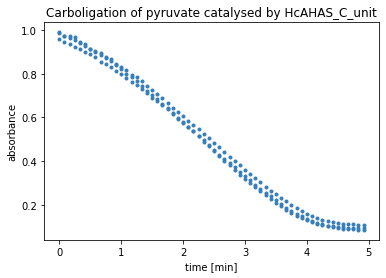

In [6]:
plt.figure()
ax = plt.subplot()
for time_course in time_course_data:
    ax.plot(time, time_course, 'o', ms=3, color='#377eb8')
plt.title('Carboligation of pyruvate catalysed by '+protein_name)
ax.set_xlabel('time ['+time_unit+']')
ax.set_ylabel('absorbance')
# save as svg
# plt.savefig('time-course.svg', bbox_inches='tight')
plt.show()

## Kinetic modelling and parameter estimation
In order to model the data and perform parameter fitting, the kinetic equations for the models are defined as Python functions, along with a function to calculate the residual between the models and the measured data.  
In the following cell 3 different models are defined.  
First the irreversible Michaelis-Menten kinetic for one substrate. Then, an extension of Michaelis-Menten introducing a lag phase in the beginning. An last a Michaelis-Menten kinetic for 2 identical substrates.  
The residual function introduces an additional bias parameter.

In [7]:
def irreversible_Michaelis_Menten(w, t, params):
    '''
    Kinetic equation according to Michaelis-Menten, 
    with the Michaelis-Menten constant K_M and v_max as as parameters.
    Arguments:
        w: vector with initial value = [s0]
        t: vector with time-steps
        parameters: parameters object from lmfit
    '''
    S = w[0]

    v_max = params['v_max'].value
    K_M = params['K_M'].value

    dS = -v_max * S/(K_M + S)
    return dS

def irreversible_Michaelis_Menten_with_lag(w, t, params):
    '''
    Kinetic equation according to Michaelis-Menten,
    extended by a term for a lag phase in the beginning,
    with the Michaelis-Menten constant K_M and v_max and a as as parameters.
    Arguments:
        w: vector with initial values = [s0, v0]
        t: vector with time-steps
        parameters: parameters object from lmfit
    '''
    S = w[0]
    v = w[1]

    K_M = params['K_M'].value
    v_max = params['v_max'].value
    a = params['a'].value

    dS = -v*S/(K_M + S)
    dv = a*(v_max-v)

    return (dS, dv)

def irreversible_Michaelis_Menten_with_2substrates_with_lag(w, t, params):
    '''
    Kinetic equation according to Michaelis-Menten 
    for 2 identical substrates,
    with k_i, k_s, v_max and a as as parameters.
    Arguments:
        w: vector with initial values = [s0, v0]
        t: vector with time-steps
        parameters: parameters object from lmfit
    '''
    S = w[0]
    v = w[1]

    k_i = params['K_i'].value
    k_s = params['K_s'].value
    v_max = params['v_max'].value
    a = params['a'].value

    dS = -v*S**2/(k_i*k_s + 2*k_s*S + S**2)
    dv = a*(v_max-v)

    return (dS, dv)

In [8]:
def residual(params, t, data, f):
    '''
    Calculates residual between measured data and modelled data.
    Arguments:
        params: parameters object from lmfit
        t: time
        data: measured data
        f: ODEs
    '''
    try:
        w = params['S_0'].value, params['v_0'].value
    except KeyError:
        w = params['S_0'].value
    bias = params['bias'].value
    ndata = data.shape[0]
    residual = 0.0*data[:]
    for i in range(ndata):
        s_modelled = odeint(f, w, t, args=(params,))
        s_modelled = s_modelled[:,0]
        residual[i,:]= data[i,:] - (s_modelled + bias)
    return residual.flatten()

### Initialising parameters 
The Python library lmfit provides a parameter object to initialise the parameters before the fit.

In [9]:
s_0 = round(np.mean(time_course_data, axis=0)[0],4)
slope, intercept, r, p, se = stats.linregress(time, time_course_data[0])
v_max = round(abs(slope), 4)
bias = round(np.mean(time_course_data, axis=0)[-1],4)

In [10]:
# Parameters for irreversible Michaelis-Menten without lag or bias
params_MM = Parameters()
params_MM.add('S_0', value=s_0, min=0.1, max=s_0+0.2*s_0)
params_MM.add('v_max', value=v_max, min=0.00001, max=10.)
params_MM.add('K_M', value=s_0, min=0.00001, max=s_0*10)
params_MM.add('bias', value=0, vary=False)

# Parameters for Michaelis-Menten with bias
params_with_bias = Parameters()
params_with_bias.add('S_0', value=s_0-bias, min=0.1, max=s_0+0.2*s_0)
params_with_bias.add('bias', value=bias, min=0.0001, max=s_0*0.5)
params_with_bias.add('v_max', value=v_max, min=0.00001, max=10.)
params_with_bias.add('K_M', value=s_0, min=0.00001, max=s_0*10)

In [11]:

# Parameters for Michaelis-Menten with lag
params_with_lag = Parameters()
params_with_lag.add('v_0', value=0, vary=False)
params_with_lag.add('S_0', value=s_0, min=0.1, max=s_0+0.2*s_0)
params_with_lag.add('a', value=1., min=0.0001, max=10.)
params_with_lag.add('v_max', value=v_max, min=0.0001, max=10.)
params_with_lag.add('K_M', value=s_0, min=0.0001, max=s_0*10)
params_with_lag.add('bias', value=0, vary=False)

# Parameters for Michaelis-Menten with lag and bias
params_with_lag_bias = Parameters()
params_with_lag_bias.add('v_0', value=0, vary=False)
params_with_lag_bias.add('S_0', value=s_0-bias, min=0.1, max=s_0)
params_with_lag_bias.add('bias', value=bias, min=0.001, max=s_0*0.5)
params_with_lag_bias.add('a', value=1., min=0.0001, max=10.)
params_with_lag_bias.add('v_max', value=v_max, min=0.0001, max=10.)
params_with_lag_bias.add('K_M', value=s_0, min=0.0001, max=s_0*10)

In [12]:
# Parameters for Michaelis-Menten with 2 substrates and lag and bias
params_MM_2S_lag_b = Parameters()
params_MM_2S_lag_b.add('S_0', value=s_0, min=0.1, max=s_0+0.2*s_0)
params_MM_2S_lag_b.add('v_max', value=v_max, min=0.0001, max=10.)
params_MM_2S_lag_b.add('v_0', value=0, vary=False)
params_MM_2S_lag_b.add('a', value=1., min=0.0001, max=10.)
params_MM_2S_lag_b.add('K_s', value=s_0, min=0.0001, max=s_0*10)
params_MM_2S_lag_b.add('K_i', value=s_0, min=0.0001, max=s_0*10)
params_MM_2S_lag_b.add('bias', value=bias, min=0.001, max=s_0*0.5)

### Parameter fitting
In the next cell the parameters for all models are fitted against the measured data and the results are stored in a dictionary.

In [13]:
results_dict = {}
# model 1: irreversible Michaelis-Menten
result_MM = minimize(residual, params_MM, args=(time, time_course_data, irreversible_Michaelis_Menten), method='leastsq')
results_dict['irreversible Michaelis-Menten'] = result_MM

# model 2: Michaelis-Menten with bias
result_MM_with_bias = minimize(residual, params_with_bias, args=(time, time_course_data, irreversible_Michaelis_Menten), method='leastsq')
results_dict['irrev. Michaelis-Menten with bias'] = result_MM_with_bias

# model 3: Michaelis-Menten with lag
result_MM_with_lag = minimize(residual, params_with_lag, args=(time, time_course_data, irreversible_Michaelis_Menten_with_lag), method='leastsq')
results_dict['irrev. Michaelis-Menten with lag'] = result_MM_with_lag

# model 4: Michaelis-Menten with lag and bias
result_with_lag_bias = minimize(residual, params_with_lag_bias, args=(time, time_course_data, irreversible_Michaelis_Menten_with_lag), method='leastsq')
results_dict['irrev. Michaelis-Menten with lag and bias'] = result_with_lag_bias

# model 5: Michaelis-Menten with 2 substrates and lag and bias
result_2substrates_with_lag_bias = minimize(residual, params_MM_2S_lag_b, args=(time, time_course_data, irreversible_Michaelis_Menten_with_2substrates_with_lag), method='leastsq')
results_dict['irrev. Michaelis-Menten with 2 substrates'] = result_2substrates_with_lag_bias

### Results Model 1
The output of the next cell shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters for model 1.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 180
    # variables        = 3
    chi-square         = 0.13461328
    reduced chi-square = 7.6053e-04
    Akaike info crit   = -1289.69509
    Bayesian info crit = -1280.11622
[[Variables]]
    S_0:    1.03341902 +/- 0.00544760 (0.53%) (init = 0.9781)
    v_max:  0.26204784 +/- 0.00754536 (2.88%) (init = 0.2034)
    K_M:    0.09591097 +/- 0.01488774 (15.52%) (init = 0.9781)
    bias:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(v_max, K_M) = 0.962
    C(S_0, v_max) = 0.745
    C(S_0, K_M)   = 0.581


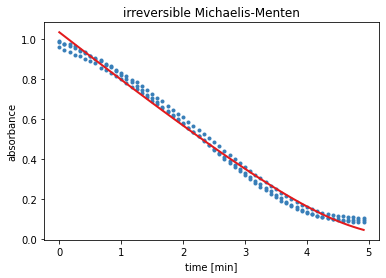

In [14]:
result = results_dict['irreversible Michaelis-Menten']
report_fit(result)
w0 = result.params['S_0'].value
data_fitted = odeint(irreversible_Michaelis_Menten, w0, time, args=(result.params,))
plt.figure()
ax = plt.subplot()
for i in range(time_course_data.shape[0]):
    ax.plot(time, time_course_data[i, :], 'o', ms=3, color='#377eb8')
ax.plot(time, data_fitted[:], '-', linewidth=2, color='#e31a1c')
ax.set_xlabel('time ['+time_unit+']')
ax.set_ylabel('absorbance')
plt.title('irreversible Michaelis-Menten')
# save as svg
# plt.savefig('model1.svg', bbox_inches='tight')
plt.show()

### Results Model 2
The output of the next cell shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters for model 2.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 84
    # data points      = 180
    # variables        = 4
    chi-square         = 0.08045348
    reduced chi-square = 4.5712e-04
    Akaike info crit   = -1380.34595
    Bayesian info crit = -1367.57412
[[Variables]]
    S_0:    0.91873842 +/- 0.00556701 (0.61%) (init = 0.8834)
    bias:   0.10519450 +/- 0.00390504 (3.71%) (init = 0.0947)
    v_max:  0.22527539 +/- 0.00322714 (1.43%) (init = 0.2034)
    K_M:    0.00172692 +/- 0.00406302 (235.28%) (init = 0.9781)
[[Correlations]] (unreported correlations are < 0.100)
    C(v_max, K_M) = 0.888
    C(S_0, bias)  = -0.711
    C(S_0, v_max) = 0.563
    C(S_0, K_M)   = 0.367


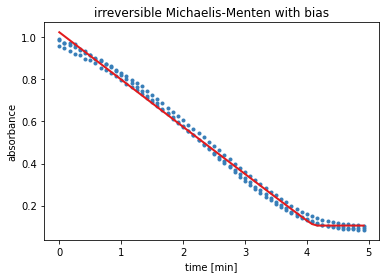

In [15]:
result = results_dict['irrev. Michaelis-Menten with bias']
report_fit(result)
w0 = result.params['S_0'].value
data_fitted = odeint(irreversible_Michaelis_Menten, w0, time, args=(result.params,))
plt.figure()
ax = plt.subplot()
for i in range(time_course_data.shape[0]):
    ax.plot(time, time_course_data[i, :], 'o', ms=3, color='#377eb8')
ax.plot(time, data_fitted[:]+result.params['bias'].value, '-', linewidth=2, color='#e31a1c')
ax.set_xlabel('time ['+time_unit+']')
ax.set_ylabel('absorbance')
plt.title('irreversible Michaelis-Menten with bias')
# save as svg
# plt.savefig('model2.svg', bbox_inches='tight')
plt.show()

### Results Model 3
The output of the next cell shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters for model 3.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 225
    # data points      = 180
    # variables        = 4
    chi-square         = 0.05793438
    reduced chi-square = 3.2917e-04
    Akaike info crit   = -1439.45220
    Bayesian info crit = -1426.68037
[[Variables]]
    v_0:    0 (fixed)
    S_0:    0.95065756 +/- 0.00409313 (0.43%) (init = 0.9781)
    a:      0.85685357 +/- 0.16152914 (18.85%) (init = 1)
    v_max:  0.59389031 +/- 0.12514705 (21.07%) (init = 0.2034)
    K_M:    0.50293833 +/- 0.14107303 (28.05%) (init = 0.9781)
    bias:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(v_max, K_M) = 0.995
    C(a, v_max)   = -0.979
    C(a, K_M)     = -0.956
    C(S_0, a)     = 0.642
    C(S_0, v_max) = -0.534
    C(S_0, K_M)   = -0.492


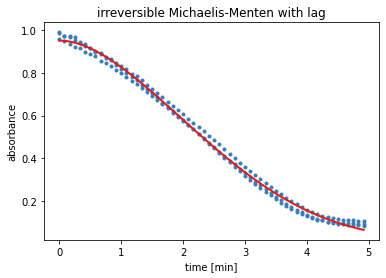

In [16]:
result = results_dict['irrev. Michaelis-Menten with lag']
report_fit(result)
w0 = result.params['S_0'].value, result.params['v_0'].value
data_fitted = odeint(irreversible_Michaelis_Menten_with_lag, w0, time, args=(result.params,))
plt.figure()
ax = plt.subplot()
for i in range(time_course_data.shape[0]):
    ax.plot(time, time_course_data[i, :], 'o', ms=3, color='#377eb8')
ax.plot(time, data_fitted[:,0]+result.params['bias'].value, '-', linewidth=2, color='#e31a1c')
ax.set_xlabel('time ['+time_unit+']')
ax.set_ylabel('absorbance')
plt.title('irreversible Michaelis-Menten with lag')
# save as svg
# plt.savefig('model3.svg', bbox_inches='tight')
plt.show()

### Results Model 4
The output of the next cell shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters for model 4.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # data points      = 180
    # variables        = 5
    chi-square         = 0.04123927
    reduced chi-square = 2.3565e-04
    Akaike info crit   = -1498.63781
    Bayesian info crit = -1482.67303
[[Variables]]
    v_0:    0 (fixed)
    S_0:    0.86085354 +/- 0.00534286 (0.62%) (init = 0.8834)
    bias:   0.09725107 +/- 0.00436842 (4.49%) (init = 0.0947)
    a:      1.69790320 +/- 0.15517747 (9.14%) (init = 1)
    v_max:  0.28159278 +/- 0.01082176 (3.84%) (init = 0.2034)
    K_M:    0.04761795 +/- 0.01094513 (22.99%) (init = 0.9781)
[[Correlations]] (unreported correlations are < 0.100)
    C(v_max, K_M)  = 0.947
    C(a, v_max)    = -0.895
    C(a, K_M)      = -0.743
    C(S_0, bias)   = -0.736
    C(bias, K_M)   = -0.638
    C(bias, v_max) = -0.505
    C(bias, a)     = 0.333
    C(S_0, K_M)    = 0.312
    C(S_0, a)      = 0.211
    C(S_0, v_max)  = 0.122


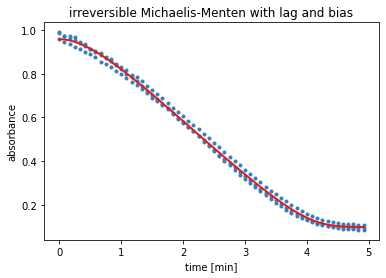

In [17]:
result = results_dict['irrev. Michaelis-Menten with lag and bias']
report_fit(result)
w0 = result.params['S_0'].value, result.params['v_0'].value
data_fitted = odeint(irreversible_Michaelis_Menten_with_lag, w0, time, args=(result.params,))
plt.figure()
ax = plt.subplot()
for i in range(time_course_data.shape[0]):
    ax.plot(time, time_course_data[i, :], 'o', ms=3, color='#377eb8')
ax.plot(time, data_fitted[:,0]+result.params['bias'].value, '-', linewidth=2, color='#e31a1c')
ax.set_xlabel('time ['+time_unit+']')
ax.set_ylabel('absorbance')
plt.title('irreversible Michaelis-Menten with lag and bias')
# save as svg
# plt.savefig('model4.svg', bbox_inches='tight')
plt.show()

### Results Model 5
The output of the next cell shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters for model 5.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 996
    # data points      = 180
    # variables        = 6
    chi-square         = 0.04049604
    reduced chi-square = 2.3274e-04
    Akaike info crit   = -1499.91142
    Bayesian info crit = -1480.75368
[[Variables]]
    S_0:    0.88452560 +/- 0.02033698 (2.30%) (init = 0.9781)
    v_max:  0.25598255 +/- 0.02517473 (9.83%) (init = 0.2034)
    v_0:    0 (fixed)
    a:      1.91322966 +/- 0.26810911 (14.01%) (init = 1)
    K_s:    4.9125e-04 +/- 0.02545279 (5181.25%) (init = 0.9781)
    K_i:    9.77992099 +/- 319.069713 (3262.50%) (init = 0.9781)
    bias:   0.07520560 +/- 0.01915032 (25.46%) (init = 0.0947)
[[Correlations]] (unreported correlations are < 0.100)
    C(K_s, K_i)    = -1.000
    C(S_0, bias)   = -0.982
    C(v_max, K_s)  = 0.976
    C(v_max, K_i)  = -0.975
    C(S_0, K_i)    = 0.895
    C(v_max, a)    = -0.895
    C(S_0, K_s)    = -0.893
    C(K_i, bias)   = -0.883
    C(K_s, bias)   = 0.880
  

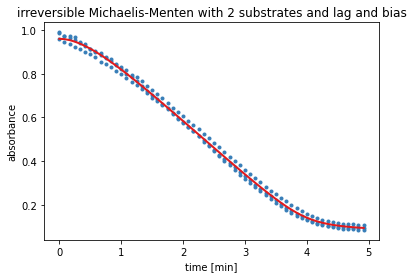

In [18]:
result = results_dict['irrev. Michaelis-Menten with 2 substrates']
report_fit(result)
w0 = result.params['S_0'].value, result.params['v_0'].value
data_fitted = odeint(irreversible_Michaelis_Menten_with_2substrates_with_lag, w0, time, args=(result.params,))
plt.figure()
ax = plt.subplot()
for i in range(time_course_data.shape[0]):
    ax.plot(time, time_course_data[i, :], 'o', ms=3, color='#377eb8')
ax.plot(time, data_fitted[:,0]+result.params['bias'].value, '-', linewidth=2, color='#e31a1c')
ax.set_xlabel('time ['+time_unit+']')
ax.set_ylabel('absorbance')
plt.title('irreversible Michaelis-Menten with 2 substrates and lag and bias')
# save as svg
# plt.savefig('model5.svg', bbox_inches='tight')
plt.show()

### Table with estimated parameters for all models

In [19]:
models_dataframe = pd.DataFrame()
for model_name, model_result in results_dict.items():
    for parameter_name, parameter_value in model_result.params.valuesdict().items():
        models_dataframe.loc[parameter_name,model_name] = round(parameter_value,3)
models_dataframe

,irreversible Michaelis-Menten,irrev. Michaelis-Menten with bias,irrev. Michaelis-Menten with lag,irrev. Michaelis-Menten with lag and bias,irrev. Michaelis-Menten with 2 substrates
S_0,1.033,0.919,0.951,0.861,0.885
v_max,0.262,0.225,0.594,0.282,0.256
K_M,0.096,0.002,0.503,0.048,NaN
bias,0.000,0.105,0.000,0.097,0.075
v_0,NaN,NaN,0.000,0.000,0.000
a,NaN,NaN,0.857,1.698,1.913
K_s,NaN,NaN,NaN,NaN,0.000
K_i,NaN,NaN,NaN,NaN,9.780


## Conversion from absorbance to concentration 
All estimated parameters are still derived from light absorption. To be comparable, S<sub>0</sub>, bias and K<sub>M</sub> are converted to concentration in mmol/L by getting divided by the molar extinction coefficient of pyruvate of 24.8 L*cm/mol and multiplied by the factor 1000 and afterwards mapped in a table.

In [20]:
models_dataframe_concentration1 = round(models_dataframe/24.8*1000,2)
models_dataframe_concentration1

,irreversible Michaelis-Menten,irrev. Michaelis-Menten with bias,irrev. Michaelis-Menten with lag,irrev. Michaelis-Menten with lag and bias,irrev. Michaelis-Menten with 2 substrates
S_0,41.65,37.06,38.35,34.72,35.69
v_max,10.56,9.07,23.95,11.37,10.32
K_M,3.87,0.08,20.28,1.94,NaN
bias,0.00,4.23,0.00,3.91,3.02
v_0,NaN,NaN,0.00,0.00,0.00
a,NaN,NaN,34.56,68.47,77.14
K_s,NaN,NaN,NaN,NaN,0.00
K_i,NaN,NaN,NaN,NaN,394.35


__Calculation of extinction coefficient__  
An alternative extinction coefficient is computed from the given initial concentration of the substrate and the estimated parameter for S<sub>0</sub> from model 4 with the formula: $\epsilon = \frac{A}{c \cdot d}$ with $A = S_0 + bias$.

In [21]:
epsilon = round((result_with_lag_bias.params['S_0'].value+result_with_lag_bias.params['bias'].value)/(50)*1000,1)
print('New extinction coefficient: '+str(epsilon)+' (cm L/mol)')

New extinction coefficient: 19.2 (cm L/mol)


In [22]:
models_dataframe_concentration2 = round(models_dataframe/epsilon*1000,2)
models_dataframe_concentration2

,irreversible Michaelis-Menten,irrev. Michaelis-Menten with bias,irrev. Michaelis-Menten with lag,irrev. Michaelis-Menten with lag and bias,irrev. Michaelis-Menten with 2 substrates
S_0,53.80,47.86,49.53,44.84,46.09
v_max,13.65,11.72,30.94,14.69,13.33
K_M,5.00,0.10,26.20,2.50,NaN
bias,0.00,5.47,0.00,5.05,3.91
v_0,NaN,NaN,0.00,0.00,0.00
a,NaN,NaN,44.64,88.44,99.64
K_s,NaN,NaN,NaN,NaN,0.00
K_i,NaN,NaN,NaN,NaN,509.38


## Upload to DaRUS
Since this scenario is part of a momentarily written paper, it will be uploaded to a DataVerse on DaRUS, the data repository of the University of Stuttgart, and get a DOI. 